In [1]:
%matplotlib inline
%load_ext memory_profiler

import pandas as pd
import os
import glob
import pickle
import phate
import scprep
import meld
import time
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scanpy as sc
from sklearn.decomposition import PCA
import math
from scipy import sparse
import sys
sys.path.append('/home/cl2292/project/')
import xgboost as xgb
import shap
from sklearn import metrics
from sklearn.model_selection import KFold
from scipy.stats import zscore, binned_statistic
from scipy.ndimage import gaussian_filter1d

from hyperopt.pyll.stochastic import sample
from timeit import default_timer as timer
from hyperopt import tpe, Trials, fmin, hp, STATUS_OK


# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")

In [2]:
# fps
dfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/data/'
pfp = '/home/cl2292/project/SCA1_snRNAseq/Mouse/results/'
sc.settings.figdir = pfp

# Load Data

if True :
    start = time.time()
    backed=None # None if not
    fname='220325_WT_imp.h5ad' # for full, can maybe get away with ~300G
    %memit wtt = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))


if True :
    start = time.time()
    backed=None # None if not
    fname='220325_SCA1_imp.h5ad' # for full, can maybe get away with ~300G
    %memit mutt = sc.read_h5ad(os.path.join(dfp,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))

peak memory: 37628.99 MiB, increment: 37419.88 MiB
loaded @220831.13:57:26
took 37.04-s to load data
peak memory: 73972.79 MiB, increment: 36351.16 MiB
loaded @220831.13:58:01
took 35.63-s to load data


### Principled Params

In [ ]:
# get the data
sns.set(font_scale=0.33)
ntop = 50
ntimebins = 20
n_bootstraps = 1 
kfolds = 10
verbose = True


mito_genes = [i for i in wtt.var_names if i.startswith('mt-')]
results = pd.DataFrame()
performance = pd.DataFrame()
for ii, ctype in enumerate(['GC']): #'AS', 'OL','UBC', 'MLI1','MG', 'MLI2', 'END', 'PER','PC','DCN','GoC', 'OPC', 'BG',
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='GC': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['sub4']==ctype), :].sample(15000).index.to_list()
            wt = wtt[(wtt.obs['sub4']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['sub4']==ctype), :].sample(15000).index.to_list()
            mut = mutt[(mutt.obs['sub4']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['sub4']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['sub4']==ctype), :]
            mut.obs['value'] = 0

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        if False:
            wt = utils.adata_phate(wt)
            mut = utils.adata_phate(mut)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        
        # strata
        X = pd.DataFrame(wt.layers['imputed'], columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()

    # bootstraps
    print('\n  starting WT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            params = {
                'verbosity': 0, 
                'validate_parameters': False,
                'eta': 0.3,  # default=0.3
                'gamma':0, # default=0
                'max_depth':100, # default=6
                'min_child_weight':5, # default=1
                'max_delta_step':0, # default=0
                'subsample':0.8, # default=0
                'sampling_method':'uniform', # default='uniform'
                'colsample_bytree':0.25, # default=1
                'colsample_bylevel':0.25, # default=1
                'colsample_bynode':0.25, # default=1
                'lambda':1, # default=1
                'alpha':0, # default=
                'scale_pos_weight':1, # default=1

                'objective':'reg:squarederror',
                'eval_metric':'rmse',
            }

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt = pd.DataFrame({'r2_wt':cv_eval, 'ctype':[ctype]*len(cv_eval)})
        print('\n  bst WT CV: {}\n'.format(np.max(cv_eval)))

    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)   

    # topn in WT, standardize in cell type and genotype 
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y']+mito_genes), :]
    topgenes = data.iloc[0:ntop, :].index.to_list() # add to this topgenes list with other model 
    
    # MUT model
    del X, y
    X = pd.DataFrame(mut.layers['imputed'], columns=mut.var_names.to_list())
    y = mut.obs['ees_t'].to_numpy()
    
    # bootstraps
    print('\n  starting MUT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt['r2_mut'] = cv_eval
        performance = performance.append(dt, ignore_index=True)
        print('\n  bst MUT CV: {}\n'.format(np.max(cv_eval)))
        performance.to_csv(os.path.join(pfp, 'top{}_dyngenes_performance.csv'.format(ntop)))
        
    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)       
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y']+mito_genes), :]
    wttop = topgenes 
    muttop = data.iloc[0:ntop, :].index.to_list() # save these and perhaps RMSE data
    topgenes = list(set(wttop + muttop)) 

    # topn, specify how to normalize
    norm_ctypeANDcondition = False
    
    if norm_ctypeANDcondition: # plot both for now
        x = pd.DataFrame(wt[:, topgenes].X.todense(), columns=topgenes)
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])
        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}.png'.format(ctype)))

        # plot same genes in mut
        mut_goi = x.index[p.dendrogram_row.reordered_ind].to_list() # in order of previous tree
        x_mut = pd.DataFrame(mut[:, mut_goi].X.todense(), columns=mut_goi)
        x_mut.loc[:, mut_goi] = zscore(x_mut.loc[:, mut_goi])
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}.png'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 14), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}.png'.format(ctype)))
        
    else: # plot both for now
        # topn in WT, standardize in cell type ONLY
        x = pd.DataFrame(wt[:, topgenes].layers['imputed'], 
                 columns=topgenes,
                 index=wt.obs.index.to_list())
        x['ctype'] = wt.obs['sub4'].to_list()
        y = pd.DataFrame(mut[:, topgenes].layers['imputed'], 
                         columns=topgenes,
                         index=mut.obs.index.to_list())
        y['ctype'] = mut.obs['sub4'].to_list()
        x = x.append(y)
        del y
        x = x.loc[x['ctype']==ctype, :]
        x = x.drop(columns='ctype')
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])

        # subset
        x_mut = x.loc[mut.obs.index]
        x = x.loc[wt.obs.index]

        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 50),
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}_ctypeNORM.pdf'.format(ctype)))

        # plot same genes in mut
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 50), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}_ctypeNORM.pdf'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
        p_diff = sns.clustermap(
                x_diff,
                pivot_kws=None,
                method='average',
                metric='euclidean',
                z_score=None,
                standard_scale=None,
                row_cluster=True,
                col_cluster=False,
                row_linkage=None,
                figsize=(4, 50), 
                col_linkage=None,
                row_colors=None,
                col_colors=timecolors,
                mask=None,
                dendrogram_ratio=0.2,
                colors_ratio=0.03,
                cbar_pos=(1, 0, 0.1, 0.15),
                tree_kws=None,
                cmap='RdYlBu_r',
                yticklabels=True,
                xticklabels=False,
                vmax=1, vmin=-1,
            )
        p_diff.ax_heatmap.set_xlabel('')

        p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}_ctypeNORM.pdf'.format(ctype)))
        
        x_diff_melted = x_diff.T.reset_index().melt(id_vars='time_grouping', var_name='topGenes', value_name='mut-wt')
        fig, ax = plt.subplots(1,1, figsize=(4,3))
        p = sns.regplot('time_grouping', 'mut-wt', data=x_diff_melted, 
                    x_estimator=None, x_bins=None, x_ci='ci', scatter=True, 
                    fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, 
                    order=1, logistic=False, lowess=True, robust=False, logx=False, x_partial=None, 
                    y_partial=None, truncate=True, dropna=True, x_jitter=0.5, y_jitter=None, 
                    label=None, color='gray', marker='o', scatter_kws={'s':1, 'alpha':0.6, 'lw':0}, line_kws=None, ax=ax)
        fig.savefig(os.path.join(pfp, 'top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        fig, ax = plt.subplots(1,1, figsize=(4,3))
        z = x_diff.abs().mean(axis=0).reset_index()
        z = z.rename(columns={0:'ave_mut-wt'})

        # histogram
        sns.barplot(x='time_grouping', y='ave_mut-wt', data=z, color='gray', ax=ax)

        # smoothed
        yprime = gaussian_filter1d(
            z['ave_mut-wt'],
            2,
            axis=-1,
            order=0,
            output=None,
            mode='nearest',
            cval=0.0,
            truncate=4.0,
        )
        ax.plot(z['time_grouping']-1, yprime, color='gray')
        ax.fill_between(z['time_grouping']-1, 0, yprime, color='gray', alpha=0.2)
        fig.savefig(os.path.join(pfp, 'hist_top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        x_diff = x_diff.reset_index()
        x_diff['ctype'] = ctype
        x_diff['top_wt'] = x_diff['index'].isin(wttop).astype(int)
        x_diff['top_mut'] = x_diff['index'].isin(muttop).astype(int) # later give info gain val

        results = results.append(x_diff, ignore_index=True)

        # intermediate save
        if verbose: # save every round
            results.to_csv(os.path.join(pfp,'top{}_dyngenes_v2.csv'.format(ntop)))
    
    print('\n... done evaluating {}.\n      took {}-min'.format(ctype, (time.time() - tic)/60))
    
results.to_csv(os.path.join(pfp,'top{}_dyngenes.csv'.format(ntop)))


Starting GC
----

computing PCA
    with n_comps=50
    finished (0:00:49)
computing neighbors
    using 'X_pca' with n_pcs = 50


The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.


    finished (0:00:13)
computing PCA
    with n_comps=50
    finished (0:00:50)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)

  starting WT model training

[0]	train-rmse:0.20636	CV1-rmse:0.20952
[500]	train-rmse:0.00024	CV1-rmse:0.05003
[531]	train-rmse:0.00024	CV1-rmse:0.05003
[0]	train-rmse:0.20713	CV2-rmse:0.20727
[500]	train-rmse:0.00024	CV2-rmse:0.05062
[527]	train-rmse:0.00024	CV2-rmse:0.05062
[0]	train-rmse:0.20712	CV3-rmse:0.20719
[500]	train-rmse:0.00024	CV3-rmse:0.04841
[525]	train-rmse:0.00024	CV3-rmse:0.04841
[0]	train-rmse:0.20653	CV4-rmse:0.21387
[500]	train-rmse:0.00024	CV4-rmse:0.04936
[530]	train-rmse:0.00024	CV4-rmse:0.04936
[0]	train-rmse:0.20689	CV5-rmse:0.20840
[500]	train-rmse:0.00024	CV5-rmse:0.04740
[522]	train-rmse:0.00024	CV5-rmse:0.04740
[0]	train-rmse:0.20653	CV6-rmse:0.21032
[500]	train-rmse:0.00024	CV6-rmse:0.04587
[518]	train-rmse:0.00024	CV6-rmse:0.04587
[0]	train-rmse:0.20622	CV7-rmse:0.21176
[500]	train-rmse:0.00024	CV7

Trying to set attribute `.obs` of view, copying.



Starting DCN
----



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)

  starting WT model training

[0]	train-rmse:0.14205	CV1-rmse:0.14451
[500]	train-rmse:0.00025	CV1-rmse:0.07442
[521]	train-rmse:0.00025	CV1-rmse:0.07442
[0]	train-rmse:0.14109	CV2-rmse:0.15281
[500]	train-rmse:0.00025	CV2-rmse:0.07314
[526]	train-rmse:0.00025	CV2-rmse:0.07314
[0]	train-rmse:0.14146	CV3-rmse:0.14725
[500]	train-rmse:0.00025	CV3-rmse:0.07074
[512]	train-rmse:0.00025	CV3-rmse:0.07074
[0]	train-rmse:0.14209	CV4-rmse:0.14151
[500]	train-rmse:0.00025	CV4-rmse:0.07443
[510]	train-rmse:0.00025	CV4-rmse:0.07443
[0]	train-rmse:0.14243	CV5-rmse:0.14588
[500]	train-rmse:0.00025	CV5-rmse:0.05820
[516]	train-rmse:0.00025	CV5-rmse:0.05820
[0]	train-rmse:0.14154	CV6-rmse:0.15316
[500]	train-rmse:0.00025	CV6-rmse:0.06649

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



... done evaluating DCN.
      took 38.23437256415685-min


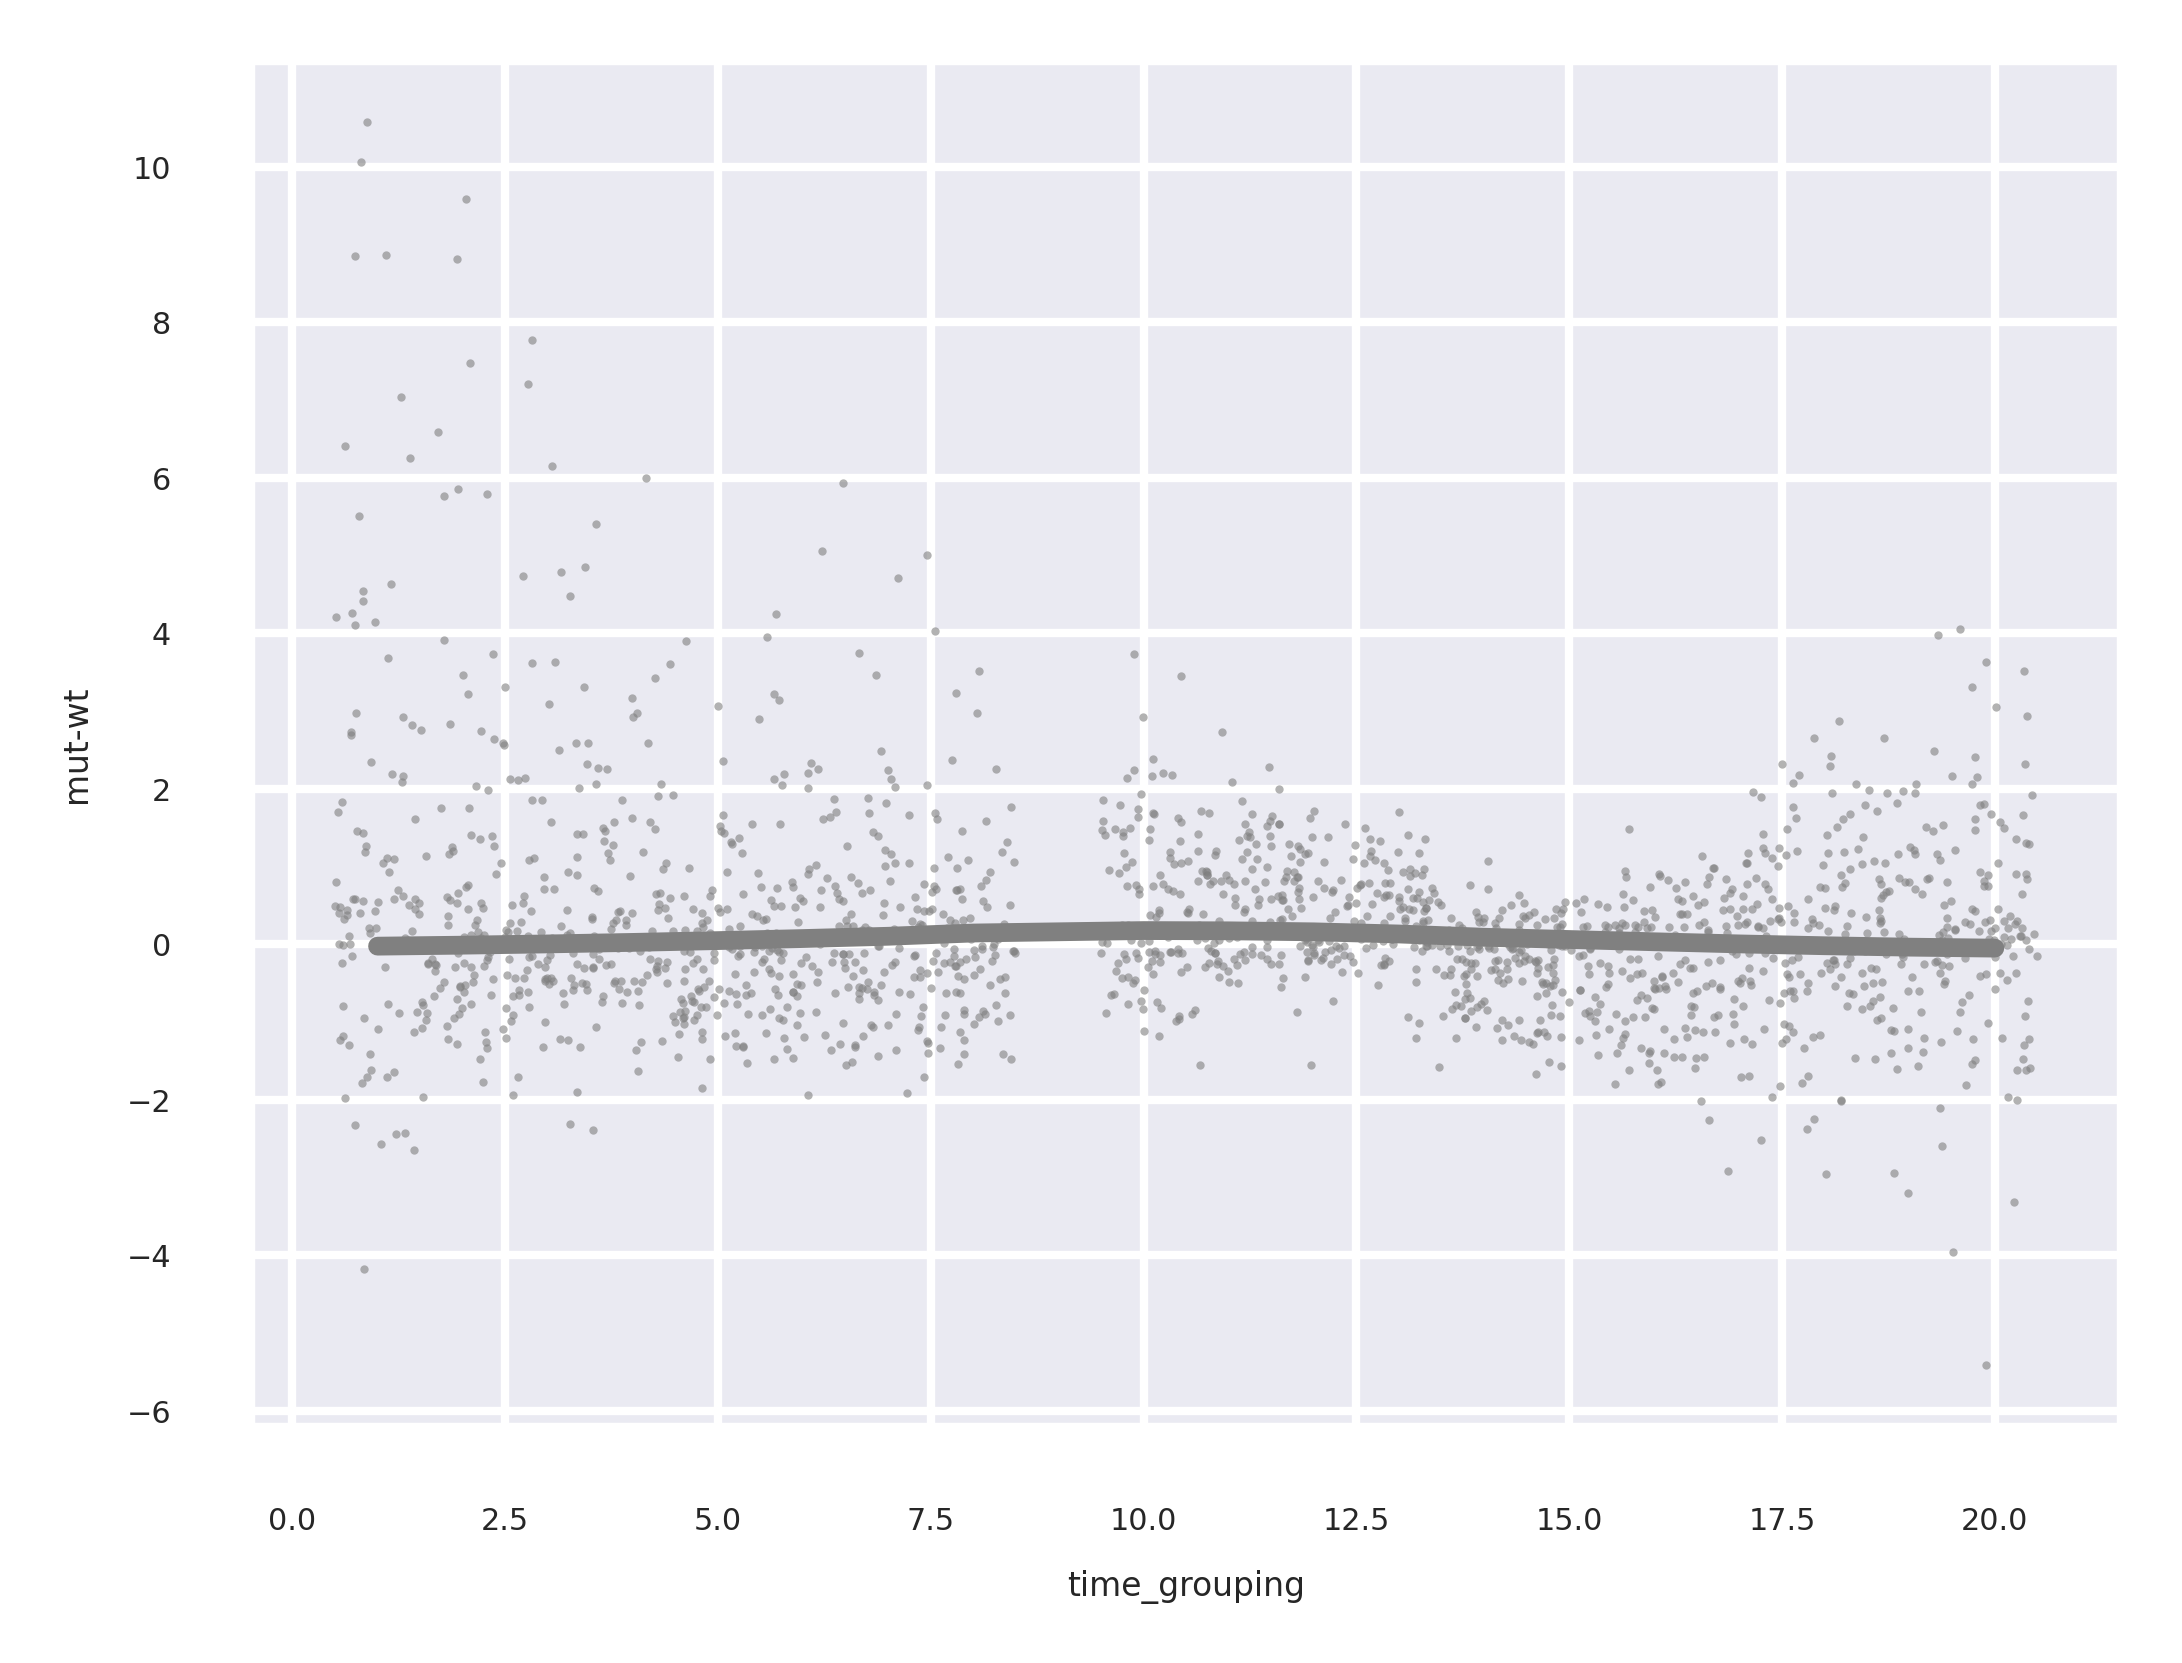

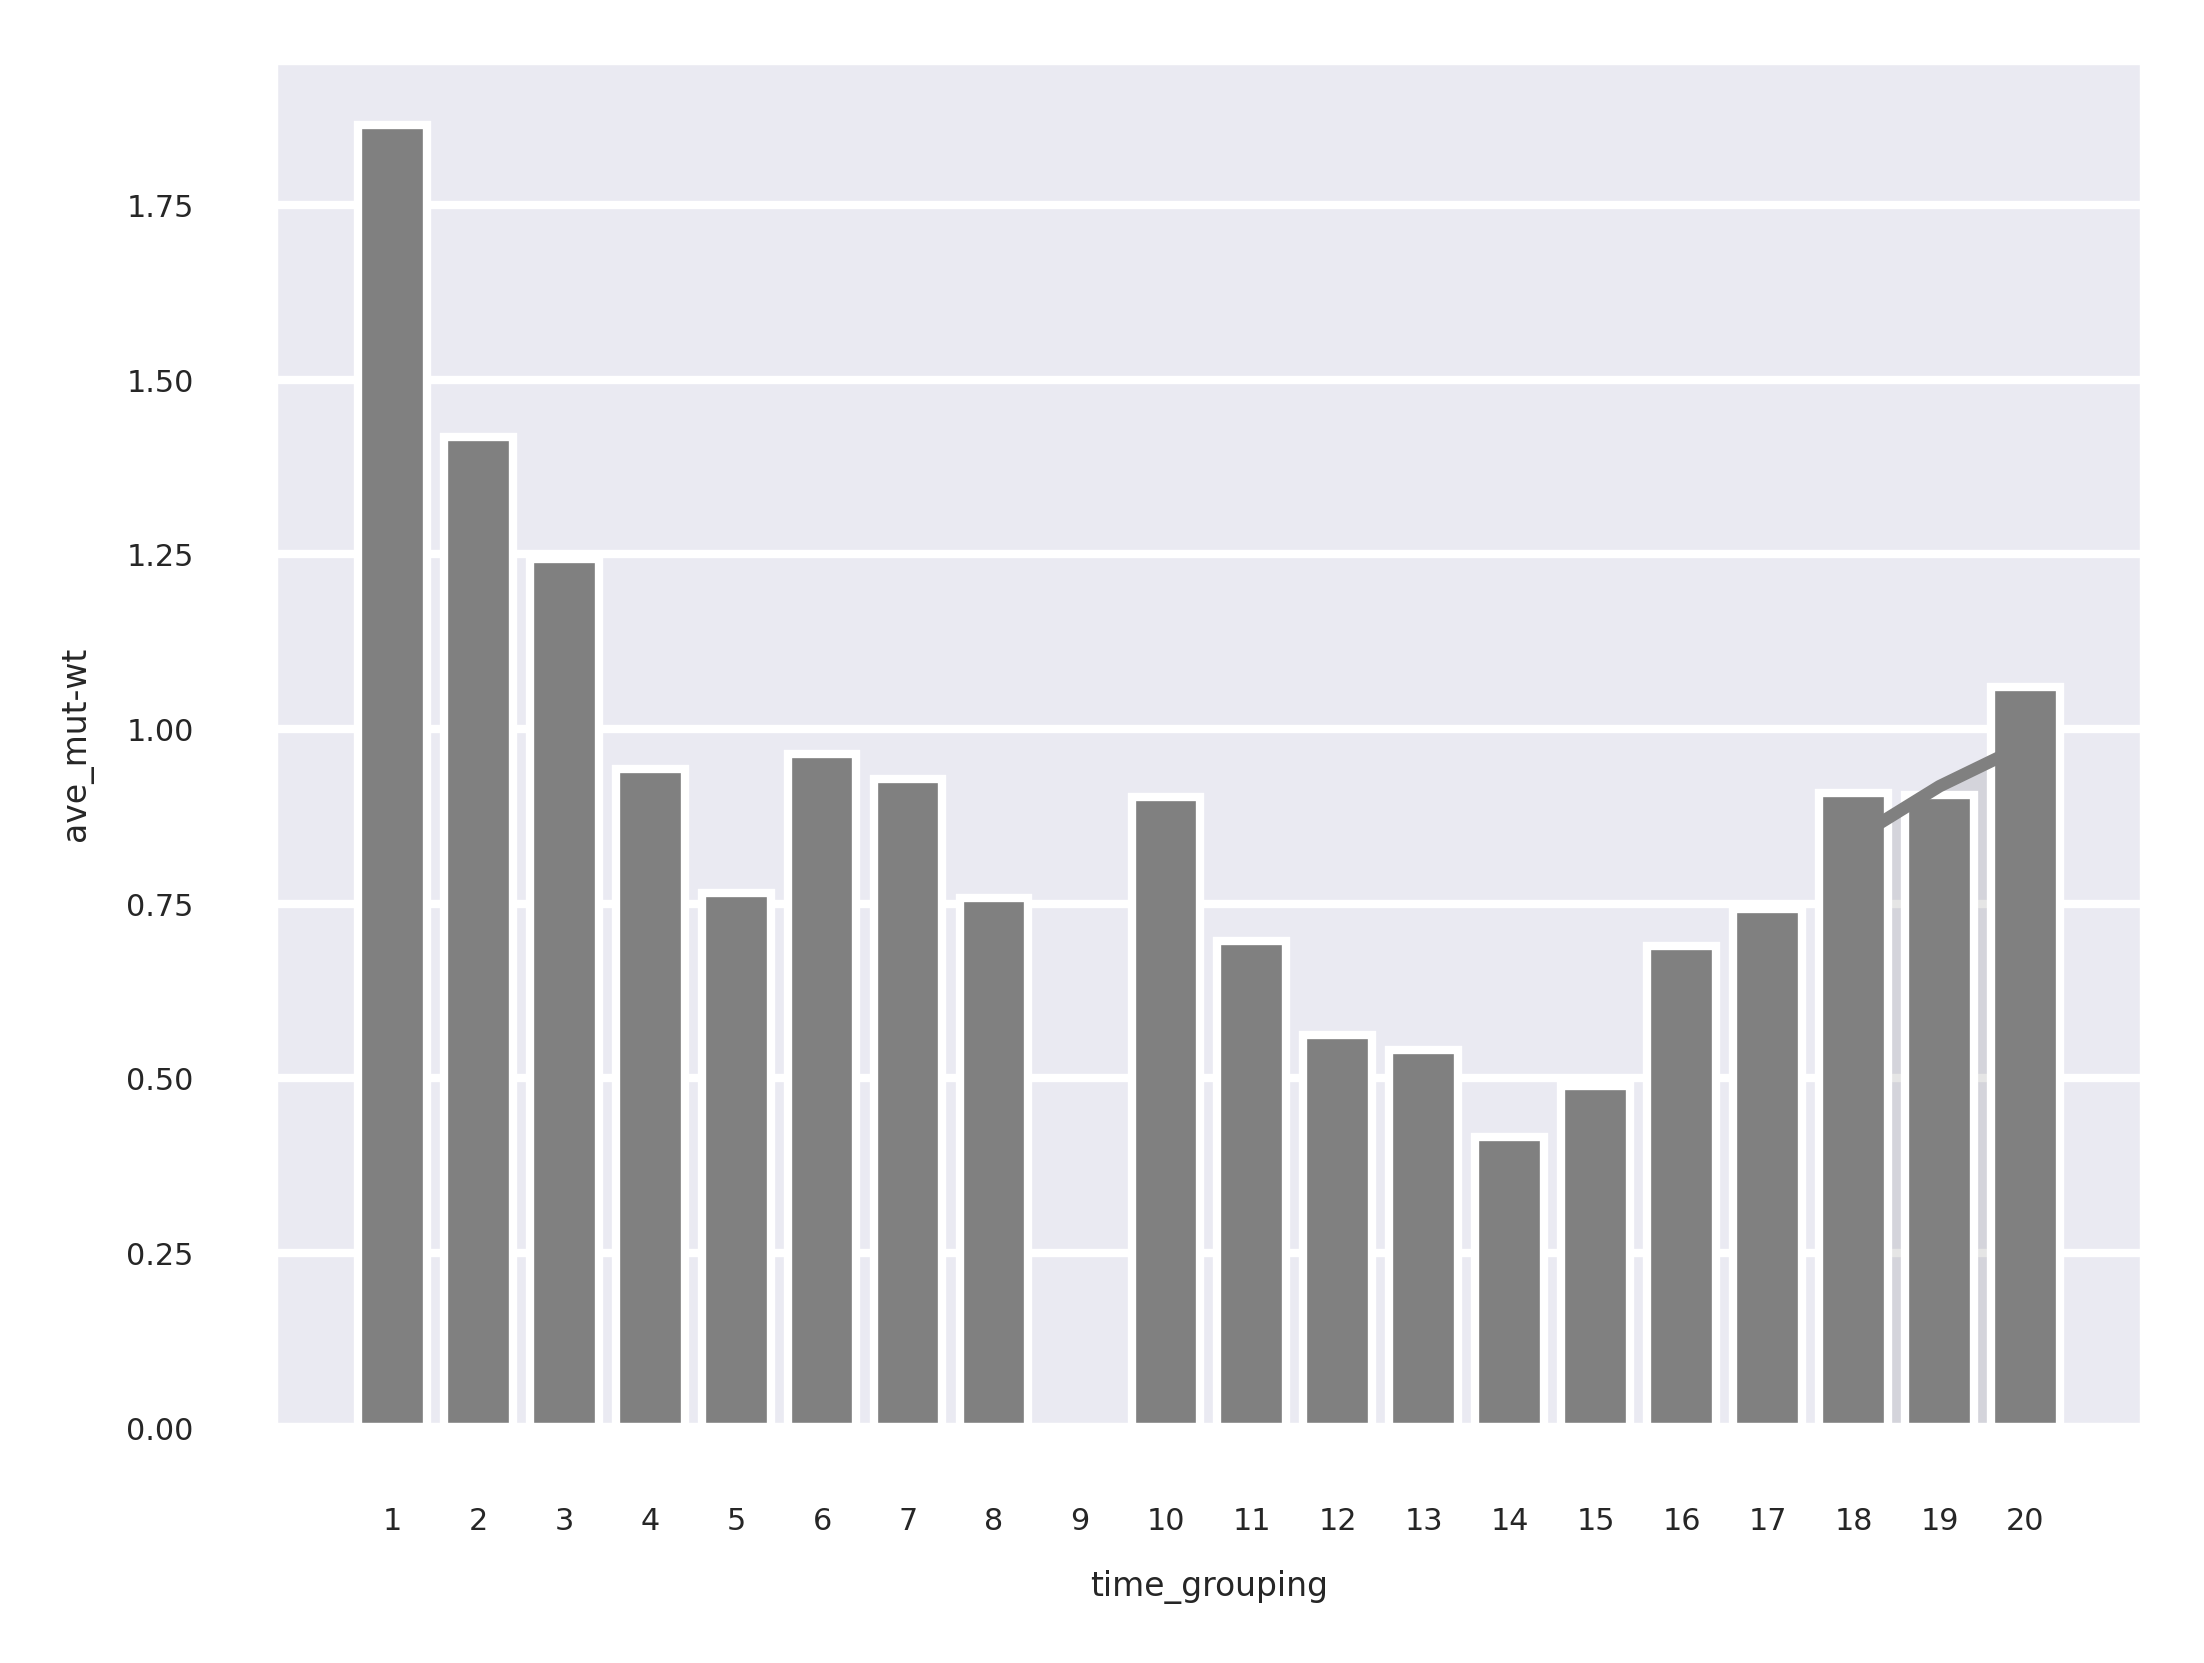

In [4]:
# get the data #DCN
sns.set(font_scale=0.33)
ntop = 50
ntimebins = 20
n_bootstraps = 1 
kfolds = 10
verbose = True


mito_genes = [i for i in wtt.var_names if i.startswith('mt-')]
results = pd.DataFrame()
performance = pd.DataFrame()
for ii, ctype in enumerate(['DCN']): #'AS', 'OL','UBC', 'MLI1','MG', 'MLI2', 'END', 'PER','PC','DCN','GoC', 'OPC', 'BG',
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='GC': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['sub4']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['sub4']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['sub4']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['sub4']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['sub4']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['sub4']==ctype), :]
            mut.obs['value'] = 0

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        if False:
            wt = utils.adata_phate(wt)
            mut = utils.adata_phate(mut)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        
        # strata
        X = pd.DataFrame(wt.layers['imputed'], columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()

    # bootstraps
    print('\n  starting WT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            params = {
                'verbosity': 0, 
                'validate_parameters': False,
                'eta': 0.3,  # default=0.3
                'gamma':0, # default=0
                'max_depth':100, # default=6
                'min_child_weight':5, # default=1
                'max_delta_step':0, # default=0
                'subsample':0.8, # default=0
                'sampling_method':'uniform', # default='uniform'
                'colsample_bytree':0.25, # default=1
                'colsample_bylevel':0.25, # default=1
                'colsample_bynode':0.25, # default=1
                'lambda':1, # default=1
                'alpha':0, # default=
                'scale_pos_weight':1, # default=1

                'objective':'reg:squarederror',
                'eval_metric':'rmse',
            }

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt = pd.DataFrame({'r2_wt':cv_eval, 'ctype':[ctype]*len(cv_eval)})
        print('\n  bst WT CV: {}\n'.format(np.max(cv_eval)))

    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)   

    # topn in WT, standardize in cell type and genotype 
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y','Tcp10c','BC027072','Gm48107']+mito_genes), :]
    topgenes = data.iloc[0:ntop, :].index.to_list() # add to this topgenes list with other model 
    
    # MUT model
    del X, y
    X = pd.DataFrame(mut.layers['imputed'], columns=mut.var_names.to_list())
    y = mut.obs['ees_t'].to_numpy()
    
    # bootstraps
    print('\n  starting MUT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt['r2_mut'] = cv_eval
        performance = performance.append(dt, ignore_index=True)
        print('\n  bst MUT CV: {}\n'.format(np.max(cv_eval)))
        performance.to_csv(os.path.join(pfp, 'top{}_dyngenes_performance.csv'.format(ntop)))
        
    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)       
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y','Tcp10c','BC027072','Gm48107']+mito_genes), :]
    wttop = topgenes 
    muttop = data.iloc[0:ntop, :].index.to_list() # save these and perhaps RMSE data
    topgenes = list(set(wttop + muttop)) 

    # topn, specify how to normalize
    norm_ctypeANDcondition = False
    
    if norm_ctypeANDcondition: # plot both for now
        x = pd.DataFrame(wt[:, topgenes].X.todense(), columns=topgenes)
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])
        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}.png'.format(ctype)))

        # plot same genes in mut
        mut_goi = x.index[p.dendrogram_row.reordered_ind].to_list() # in order of previous tree
        x_mut = pd.DataFrame(mut[:, mut_goi].X.todense(), columns=mut_goi)
        x_mut.loc[:, mut_goi] = zscore(x_mut.loc[:, mut_goi])
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=False,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 14), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}.png'.format(ctype)))

#         x_diff  = x_mut.subtract(x) # MUT - WT
#         p_diff = sns.clustermap(
#                 x_diff,
#                 pivot_kws=None,
#                 method='average',
#                 metric='euclidean',
#                 z_score=None,
#                 standard_scale=None,
#                 row_cluster=True,
#                 col_cluster=False,
#                 row_linkage=None,
#                 figsize=(4, 14), 
#                 col_linkage=None,
#                 row_colors=None,
#                 col_colors=timecolors,
#                 mask=None,
#                 dendrogram_ratio=0.2,
#                 colors_ratio=0.03,
#                 cbar_pos=(1, 0, 0.1, 0.15),
#                 tree_kws=None,
#                 cmap='RdYlBu_r',
#                 yticklabels=True,
#                 xticklabels=False,
#             )
#         p_diff.ax_heatmap.set_xlabel('')

#         p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}.png'.format(ctype)))
        
    else: # plot both for now
        # topn in WT, standardize in cell type ONLY
        x = pd.DataFrame(wt[:, topgenes].layers['imputed'], 
                 columns=topgenes,
                 index=wt.obs.index.to_list())
        x['ctype'] = wt.obs['sub4'].to_list()
        y = pd.DataFrame(mut[:, topgenes].layers['imputed'], 
                         columns=topgenes,
                         index=mut.obs.index.to_list())
        y['ctype'] = mut.obs['sub4'].to_list()
        x = x.append(y)
        del y
        x = x.loc[x['ctype']==ctype, :]
        x = x.drop(columns='ctype')
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])

        # subset
        x_mut = x.loc[mut.obs.index]
        x = x.loc[wt.obs.index]

        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]

        p = sns.clustermap(
            x,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 50),
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p.ax_heatmap.set_xlabel('')

        p.savefig(os.path.join(pfp, 'top_dyn_genes_wt_{}_ctypeNORM.pdf'.format(ctype)))

        # plot same genes in mut
        x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
        x_mut = x_mut.groupby('time_grouping').mean().T

        p_mut = sns.clustermap(
            x_mut,
            pivot_kws=None,
            method='average',
            metric='euclidean',
            z_score=None,
            standard_scale=None,
            row_cluster=True,
            col_cluster=False,
            row_linkage=None,
            figsize=(4, 50), 
            col_linkage=None,
            row_colors=None,
            col_colors=timecolors,
            mask=None,
            dendrogram_ratio=0.2,
            colors_ratio=0.03,
            cbar_pos=(1, 0, 0.1, 0.15),
            tree_kws=None,
            cmap='RdYlBu_r',
            yticklabels=True,
            xticklabels=False,
            vmax=1, vmin=-1,
        )
        p_mut.ax_heatmap.set_xlabel('')

        p_mut.savefig(os.path.join(pfp, 'top_dyn_genes_mut_{}_ctypeNORM.pdf'.format(ctype)))

        x_diff  = x_mut.subtract(x) # MUT - WT
#         p_diff = sns.clustermap(
#                 x_diff,
#                 pivot_kws=None,
#                 method='average',
#                 metric='euclidean',
#                 z_score=None,
#                 standard_scale=None,
#                 row_cluster=True,
#                 col_cluster=False,
#                 row_linkage=None,
#                 figsize=(4, 50), 
#                 col_linkage=None,
#                 row_colors=None,
#                 col_colors=timecolors,
#                 mask=None,
#                 dendrogram_ratio=0.2,
#                 colors_ratio=0.03,
#                 cbar_pos=(1, 0, 0.1, 0.15),
#                 tree_kws=None,
#                 cmap='RdYlBu_r',
#                 yticklabels=True,
#                 xticklabels=False,
#                 vmax=1, vmin=-1,
#             )
#         p_diff.ax_heatmap.set_xlabel('')

#         p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}_ctypeNORM.pdf'.format(ctype)))
        
        x_diff_melted = x_diff.T.reset_index().melt(id_vars='time_grouping', var_name='topGenes', value_name='mut-wt')
        fig, ax = plt.subplots(1,1, figsize=(4,3))
        p = sns.regplot('time_grouping', 'mut-wt', data=x_diff_melted, 
                    x_estimator=None, x_bins=None, x_ci='ci', scatter=True, 
                    fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, 
                    order=1, logistic=False, lowess=True, robust=False, logx=False, x_partial=None, 
                    y_partial=None, truncate=True, dropna=True, x_jitter=0.5, y_jitter=None, 
                    label=None, color='gray', marker='o', scatter_kws={'s':1, 'alpha':0.6, 'lw':0}, line_kws=None, ax=ax)
        fig.savefig(os.path.join(pfp, 'top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        fig, ax = plt.subplots(1,1, figsize=(4,3))
        z = x_diff.abs().mean(axis=0).reset_index()
        z = z.rename(columns={0:'ave_mut-wt'})

        # histogram
        sns.barplot(x='time_grouping', y='ave_mut-wt', data=z, color='gray', ax=ax)

        # smoothed
        yprime = gaussian_filter1d(
            z['ave_mut-wt'],
            2,
            axis=-1,
            order=0,
            output=None,
            mode='nearest',
            cval=0.0,
            truncate=4.0,
        )
        ax.plot(z['time_grouping']-1, yprime, color='gray')
        ax.fill_between(z['time_grouping']-1, 0, yprime, color='gray', alpha=0.2)
        fig.savefig(os.path.join(pfp, 'hist_top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

        x_diff = x_diff.reset_index()
        x_diff['ctype'] = ctype
        x_diff['top_wt'] = x_diff['index'].isin(wttop).astype(int)
        x_diff['top_mut'] = x_diff['index'].isin(muttop).astype(int) # later give info gain val

        results = results.append(x_diff, ignore_index=True)

        # intermediate save
        if verbose: # save every round
            results.to_csv(os.path.join(pfp,'top{}_dyngenes_v2(DCN).csv'.format(ntop)))
    
    print('\n... done evaluating {}.\n      took {}-min'.format(ctype, (time.time() - tic)/60))
    
results.to_csv(os.path.join(pfp,'top{}_dyngenes.csv'.format(ntop)))

In [3]:
# get the data #DCN
sns.set(font_scale=0.33)
ntop = 50
ntimebins = 20
n_bootstraps = 1 
kfolds = 10
verbose = True


mito_genes = [i for i in wtt.var_names if i.startswith('mt-')]
results = pd.DataFrame()
performance = pd.DataFrame()
for ii, ctype in enumerate(['DCN']): #'AS', 'OL','UBC', 'MLI1','MG', 'MLI2', 'END', 'PER','PC','DCN','GoC', 'OPC', 'BG',
    
    print('\nStarting {}'.format(ctype))
    print('----\n')
    tic = time.time()
    
    recalculate = True # gives option to tshoot
    
    if recalculate:
        if ctype=='GC': 
            # sample with replacement, ~260k granule cells, cpu can handle maybe 75k in each group?
            nsample_idx = wtt.obs.loc[(wtt.obs['sub4']==ctype), :].sample(20000).index.to_list()
            wt = wtt[(wtt.obs['sub4']==ctype) & (wtt.obs.index.isin(nsample_idx))]
            nsample_idx = mutt.obs.loc[(mutt.obs['sub4']==ctype), :].sample(20000).index.to_list()
            mut = mutt[(mutt.obs['sub4']==ctype) & (mutt.obs.index.isin(nsample_idx))]
        else:
            wt = wtt[(wtt.obs['sub4']==ctype), :]
            wt.obs['value'] = 0
            mut = mutt[(mutt.obs['sub4']==ctype), :]
            mut.obs['value'] = 0

        sc.pp.pca(wt)
        sc.pp.neighbors(wt, n_pcs=50)
        sc.pp.pca(mut)
        sc.pp.neighbors(mut, n_pcs=50)

        if False:
            wt = utils.adata_phate(wt)
            mut = utils.adata_phate(mut)

        # MELD
        G = gt.Graph(data=wt.obsp['connectivities']+sparse.diags([1]*wt.shape[0],format='csr'),
                     precomputed='adjacency',
                     use_pygsp=True)
        G.knn_max = None
        wt.obs['res_t']=-1
        wt.obs.loc[wt.obs['timepoint']=='12wk', 'res_t'] = -0.5
        wt.obs.loc[wt.obs['timepoint']=='18wk', 'res_t'] = 0
        wt.obs.loc[wt.obs['timepoint']=='24wk', 'res_t'] = 0.5
        wt.obs.loc[wt.obs['timepoint']=='30wk', 'res_t'] = 1
        wt.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=wt.obs['res_t'])
        wt.obs['ees_t'] = (wt.obs['ees_t'] - wt.obs['ees_t'].min()) / (wt.obs['ees_t'].max() - wt.obs['ees_t'].min())

        G = gt.Graph(data=mut.obsp['connectivities']+sparse.diags([1]*mut.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
        G.knn_max = None
        mut.obs['res_t']=-1
        mut.obs.loc[mut.obs['timepoint']=='12wk', 'res_t'] = -0.5
        mut.obs.loc[mut.obs['timepoint']=='18wk', 'res_t'] = 0
        mut.obs.loc[mut.obs['timepoint']=='24wk', 'res_t'] = 0.5
        mut.obs.loc[mut.obs['timepoint']=='30wk', 'res_t'] = 1
        mut.obs['ees_t'] = meld.MELD().fit_transform(G=G,RES=mut.obs['res_t'])
        mut.obs['ees_t'] = (mut.obs['ees_t'] - mut.obs['ees_t'].min()) / (mut.obs['ees_t'].max() - mut.obs['ees_t'].min())
        
        # strata
        X = pd.DataFrame(wt.layers['imputed'], columns=wt.var_names.to_list())
        y = wt.obs['ees_t'].to_numpy()

    # bootstraps
    print('\n  starting WT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            params = {
                'verbosity': 0, 
                'validate_parameters': False,
                'eta': 0.3,  # default=0.3
                'gamma':0, # default=0
                'max_depth':100, # default=6
                'min_child_weight':5, # default=1
                'max_delta_step':0, # default=0
                'subsample':0.8, # default=0
                'sampling_method':'uniform', # default='uniform'
                'colsample_bytree':0.25, # default=1
                'colsample_bylevel':0.25, # default=1
                'colsample_bynode':0.25, # default=1
                'lambda':1, # default=1
                'alpha':0, # default=
                'scale_pos_weight':1, # default=1

                'objective':'reg:squarederror',
                'eval_metric':'rmse',
            }

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt = pd.DataFrame({'r2_wt':cv_eval, 'ctype':[ctype]*len(cv_eval)})
        print('\n  bst WT CV: {}\n'.format(np.max(cv_eval)))

    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)   

    # topn in WT, standardize in cell type and genotype 
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y','Tcp10c','BC027072','Gm48107']+mito_genes), :]
    topgenes = data.iloc[0:ntop, :].index.to_list() # add to this topgenes list with other model 
    
    # MUT model
    del X, y
    X = pd.DataFrame(mut.layers['imputed'], columns=mut.var_names.to_list())
    y = mut.obs['ees_t'].to_numpy()
    
    # bootstraps
    print('\n  starting MUT model training\n')
    for n_iter in range(n_bootstraps):
        kf = KFold(n_splits=kfolds, shuffle=True)

        cv_eval = []
        cv_fold_counter = 0
        for train_index, test_index in kf.split(X):
            cv_fold_counter += 1
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            dtrain = xgb.DMatrix(X_train, y_train)
            dval = xgb.DMatrix(X_test, y_test)

            cvmod = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=5000,
                        evals=([(dtrain,'train'), (dval,'CV{}'.format(cv_fold_counter))]),
                        obj=None,
                        feval=None,
                        maximize=False,
                        early_stopping_rounds=500,
                        evals_result=None,
                        verbose_eval=500,
                        xgb_model=None,
                        callbacks=None,
                    )

            y_true = y_test 
            y_pred = cvmod.predict(dval)
            cv_eval.append(metrics.r2_score(y_true, y_pred))

            if cv_eval[-1] >= np.max(cv_eval):
                bst = cvmod
                X_train_bst, X_test_bst = X_train, X_test
                y_train_bst, y_test_bst = y_train, y_test
                
    if verbose:
        dt['r2_mut'] = cv_eval
        performance = performance.append(dt, ignore_index=True)
        print('\n  bst MUT CV: {}\n'.format(np.max(cv_eval)))
        performance.to_csv(os.path.join(pfp, 'top{}_dyngenes_performance.csv'.format(ntop)))
        
    feature_important = bst.get_score(importance_type='gain')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)       
    data = data.loc[~data.index.isin(['Xist', 'Tsix', 'Eif2s3y','Tcp10c','BC027072','Gm48107']+mito_genes), :]
    wttop = topgenes 
    muttop = data.iloc[0:ntop, :].index.to_list() # save these and perhaps RMSE data
    topgenes = list(set(wttop + muttop)) 

    if True:
        x = pd.DataFrame(wt[:, topgenes].layers['imputed'], 
                 columns=topgenes,
                 index=wt.obs.index.to_list())
        x['ctype'] = wt.obs['sub4'].to_list()
        y = pd.DataFrame(mut[:, topgenes].layers['imputed'], 
                         columns=topgenes,
                         index=mut.obs.index.to_list())
        y['ctype'] = mut.obs['sub4'].to_list()
        x = x.append(y)
        del y
        x = x.loc[x['ctype']==ctype, :]
        x = x.drop(columns='ctype')
        x.loc[:, topgenes] = zscore(x.loc[:, topgenes])

        # subset
        x_mut = x.loc[mut.obs.index]
        x = x.loc[wt.obs.index]

        _, _, time_groupings = binned_statistic(np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), 
                                                np.concatenate((wt.obs['ees_t'].to_numpy(), mut.obs['ees_t'].to_numpy())), bins=ntimebins)
        x['time_grouping'] = time_groupings[0:wt.shape[0]]
        x = x.groupby('time_grouping').mean().T

        cm = plt.get_cmap('magma')
        timecolors = [cm(1.*i/ntimebins) for i in range(ntimebins)]




Trying to set attribute `.obs` of view, copying.



Starting DCN
----



Trying to set attribute `.obs` of view, copying.


computing PCA
    with n_comps=50
    finished (0:00:12)
computing neighbors
    using 'X_pca' with n_pcs = 50


The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.


    finished (0:00:06)
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)

  starting WT model training

[0]	train-rmse:0.14205	CV1-rmse:0.14451
[500]	train-rmse:0.00025	CV1-rmse:0.07442
[522]	train-rmse:0.00025	CV1-rmse:0.07442
[0]	train-rmse:0.14109	CV2-rmse:0.15281
[500]	train-rmse:0.00025	CV2-rmse:0.07314
[527]	train-rmse:0.00025	CV2-rmse:0.07314
[0]	train-rmse:0.14146	CV3-rmse:0.14725
[500]	train-rmse:0.00025	CV3-rmse:0.07074
[511]	train-rmse:0.00025	CV3-rmse:0.07074
[0]	train-rmse:0.14209	CV4-rmse:0.14151
[500]	train-rmse:0.00025	CV4-rmse:0.07443
[511]	train-rmse:0.00025	CV4-rmse:0.07443
[0]	train-rmse:0.14243	CV5-rmse:0.14588
[500]	train-rmse:0.00025	CV5-rmse:0.05820
[515]	train-rmse:0.00025	CV5-rmse:0.05820
[0]	train-rmse:0.14154	CV6-rmse:0.15316
[500]	train-rmse:0.00025	CV6-rmse:0.06649
[529]	train-rmse:0.00025	CV6-rmse:0.06649
[0]	train-rmse:0.14124	CV7-rmse:0.15835
[500]	train-rmse:0.00026	CV7

In [4]:
# plot same genes in mut
x_mut['time_grouping'] = time_groupings[wt.shape[0]:]
x_mut = x_mut.groupby('time_grouping').mean().T


x_diff  = x_mut.subtract(x) # MUT - WT


KeyError: '9'

In [10]:
y_diff=x_diff.drop(columns=[9])

In [11]:
y_diff

time_grouping,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20
Acap2,2.971187,3.459220,3.313458,2.590862,1.291913,2.197818,1.692486,1.063450,0.650020,0.819008,0.701869,0.709410,-0.320921,-0.530112,-0.432351,0.546374,0.495818,1.251402,2.066759
Lncpint,2.164848,1.757661,1.414273,0.725460,-0.022355,0.596183,0.448343,0.341033,0.010576,0.225340,0.530974,0.791412,-0.611403,-0.680524,-0.891950,-1.133321,-0.601732,-0.308080,-0.156088
Khdc1b,0.002679,-0.025963,-0.041401,0.066644,-0.117792,-0.047502,-0.122135,-0.116762,-0.126369,0.057252,-0.133014,1.694878,0.178576,0.222535,0.000633,0.019611,-0.203814,0.006015,0.068191
Cxxc4,1.615079,0.362854,0.013864,0.054747,-1.322809,-0.869928,-1.399986,-1.333108,-0.926822,-0.211036,-0.007237,0.165410,-0.319642,-0.293906,0.114313,0.243593,1.760472,1.980788,-0.921570
Coch,0.377788,0.080859,0.157194,0.517114,0.016423,-0.186296,-0.618743,-0.453974,-0.140345,-0.121040,0.042927,1.402253,0.204641,-0.146259,-1.615968,-2.516151,-1.194339,-3.198763,-5.418529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samd5,4.102824,1.251677,0.530595,0.169738,-0.651757,1.012808,0.658260,0.745007,1.487122,0.885650,0.451786,0.960447,0.711625,0.412087,-0.815607,-1.830708,-1.221496,-1.383387,-1.594322
Slc45a1,0.212599,-0.664057,-0.826252,-0.253455,-1.474357,-0.667845,-0.922396,-0.901192,1.738143,1.396784,1.051252,0.608172,-0.367337,-0.745522,-1.194795,-0.178478,0.278276,0.707276,2.412262
Gm42982,-1.232170,-1.080214,-1.230240,-0.263605,-0.570884,-0.909208,-0.709909,-0.426859,0.248099,-0.195629,0.115109,-0.527791,-0.177834,0.449341,0.249131,0.857237,1.148044,1.530276,3.517779
Ddx3y,1.269118,0.457496,0.501876,0.107829,-0.574099,0.315738,0.390428,0.311437,-0.882395,0.058009,0.364022,0.514969,0.409849,0.249956,-0.367347,-0.711589,-0.646608,-0.125543,0.169812


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



... done evaluating DCN.
      took 44.46790134906769-min


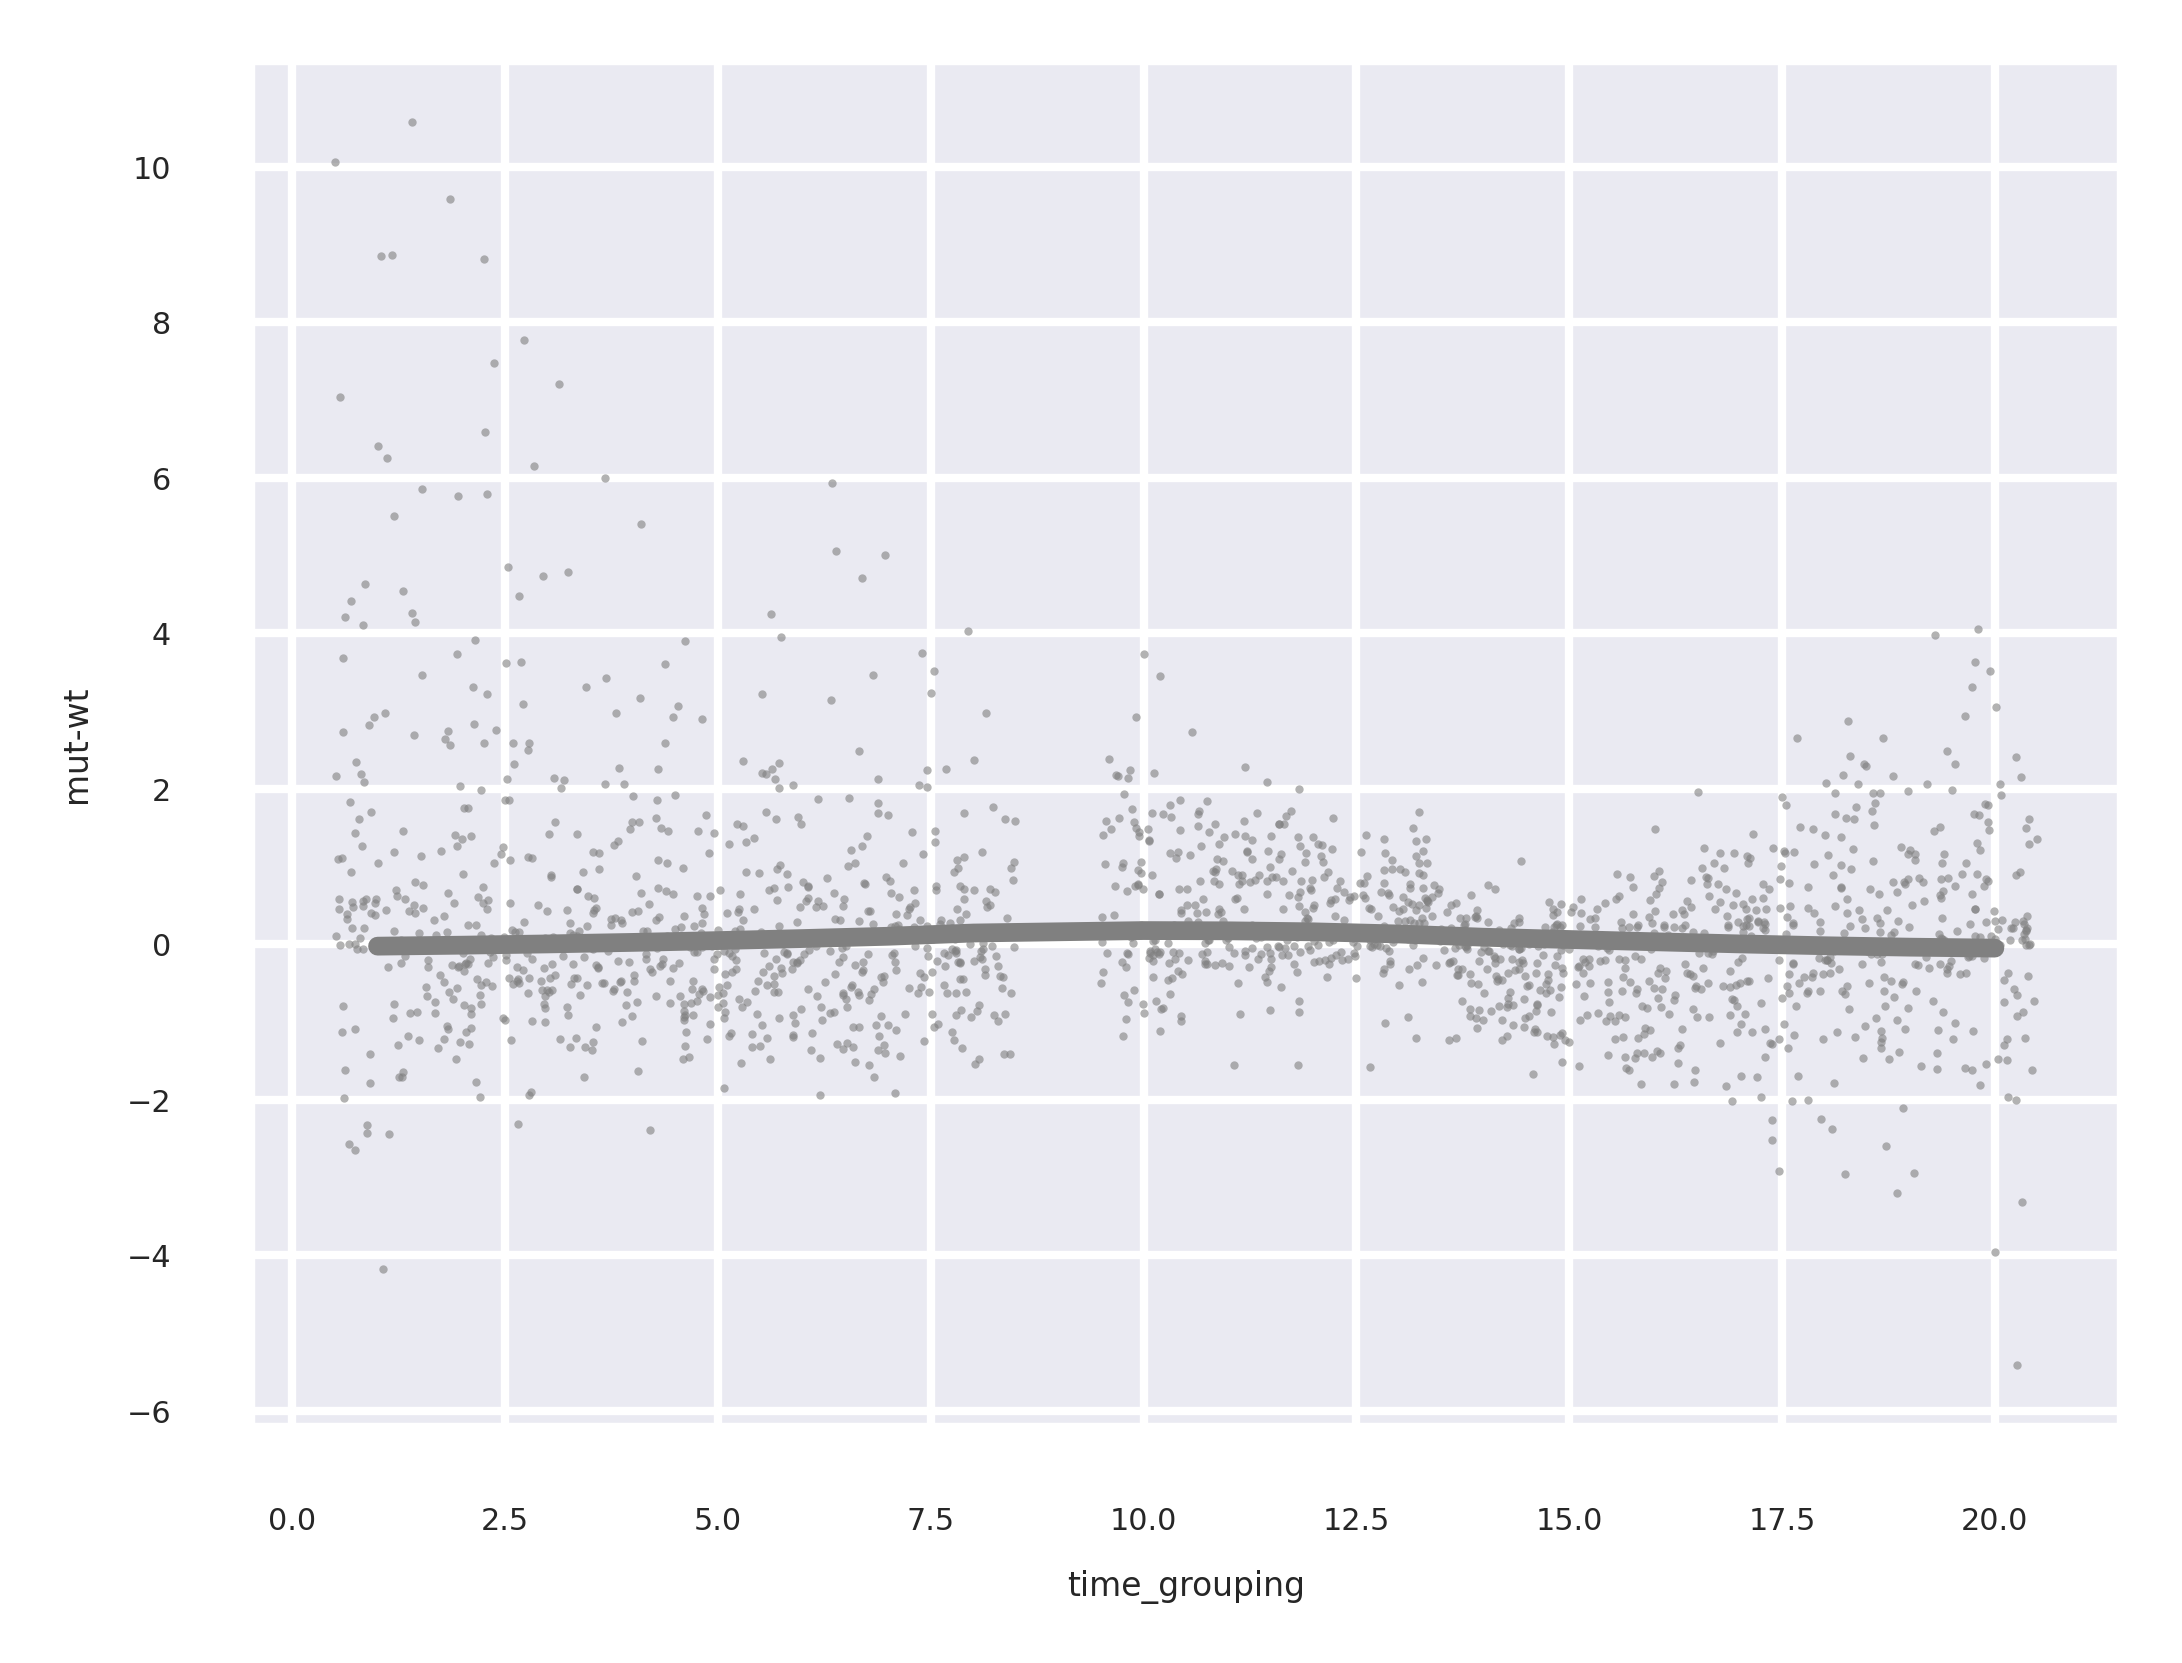

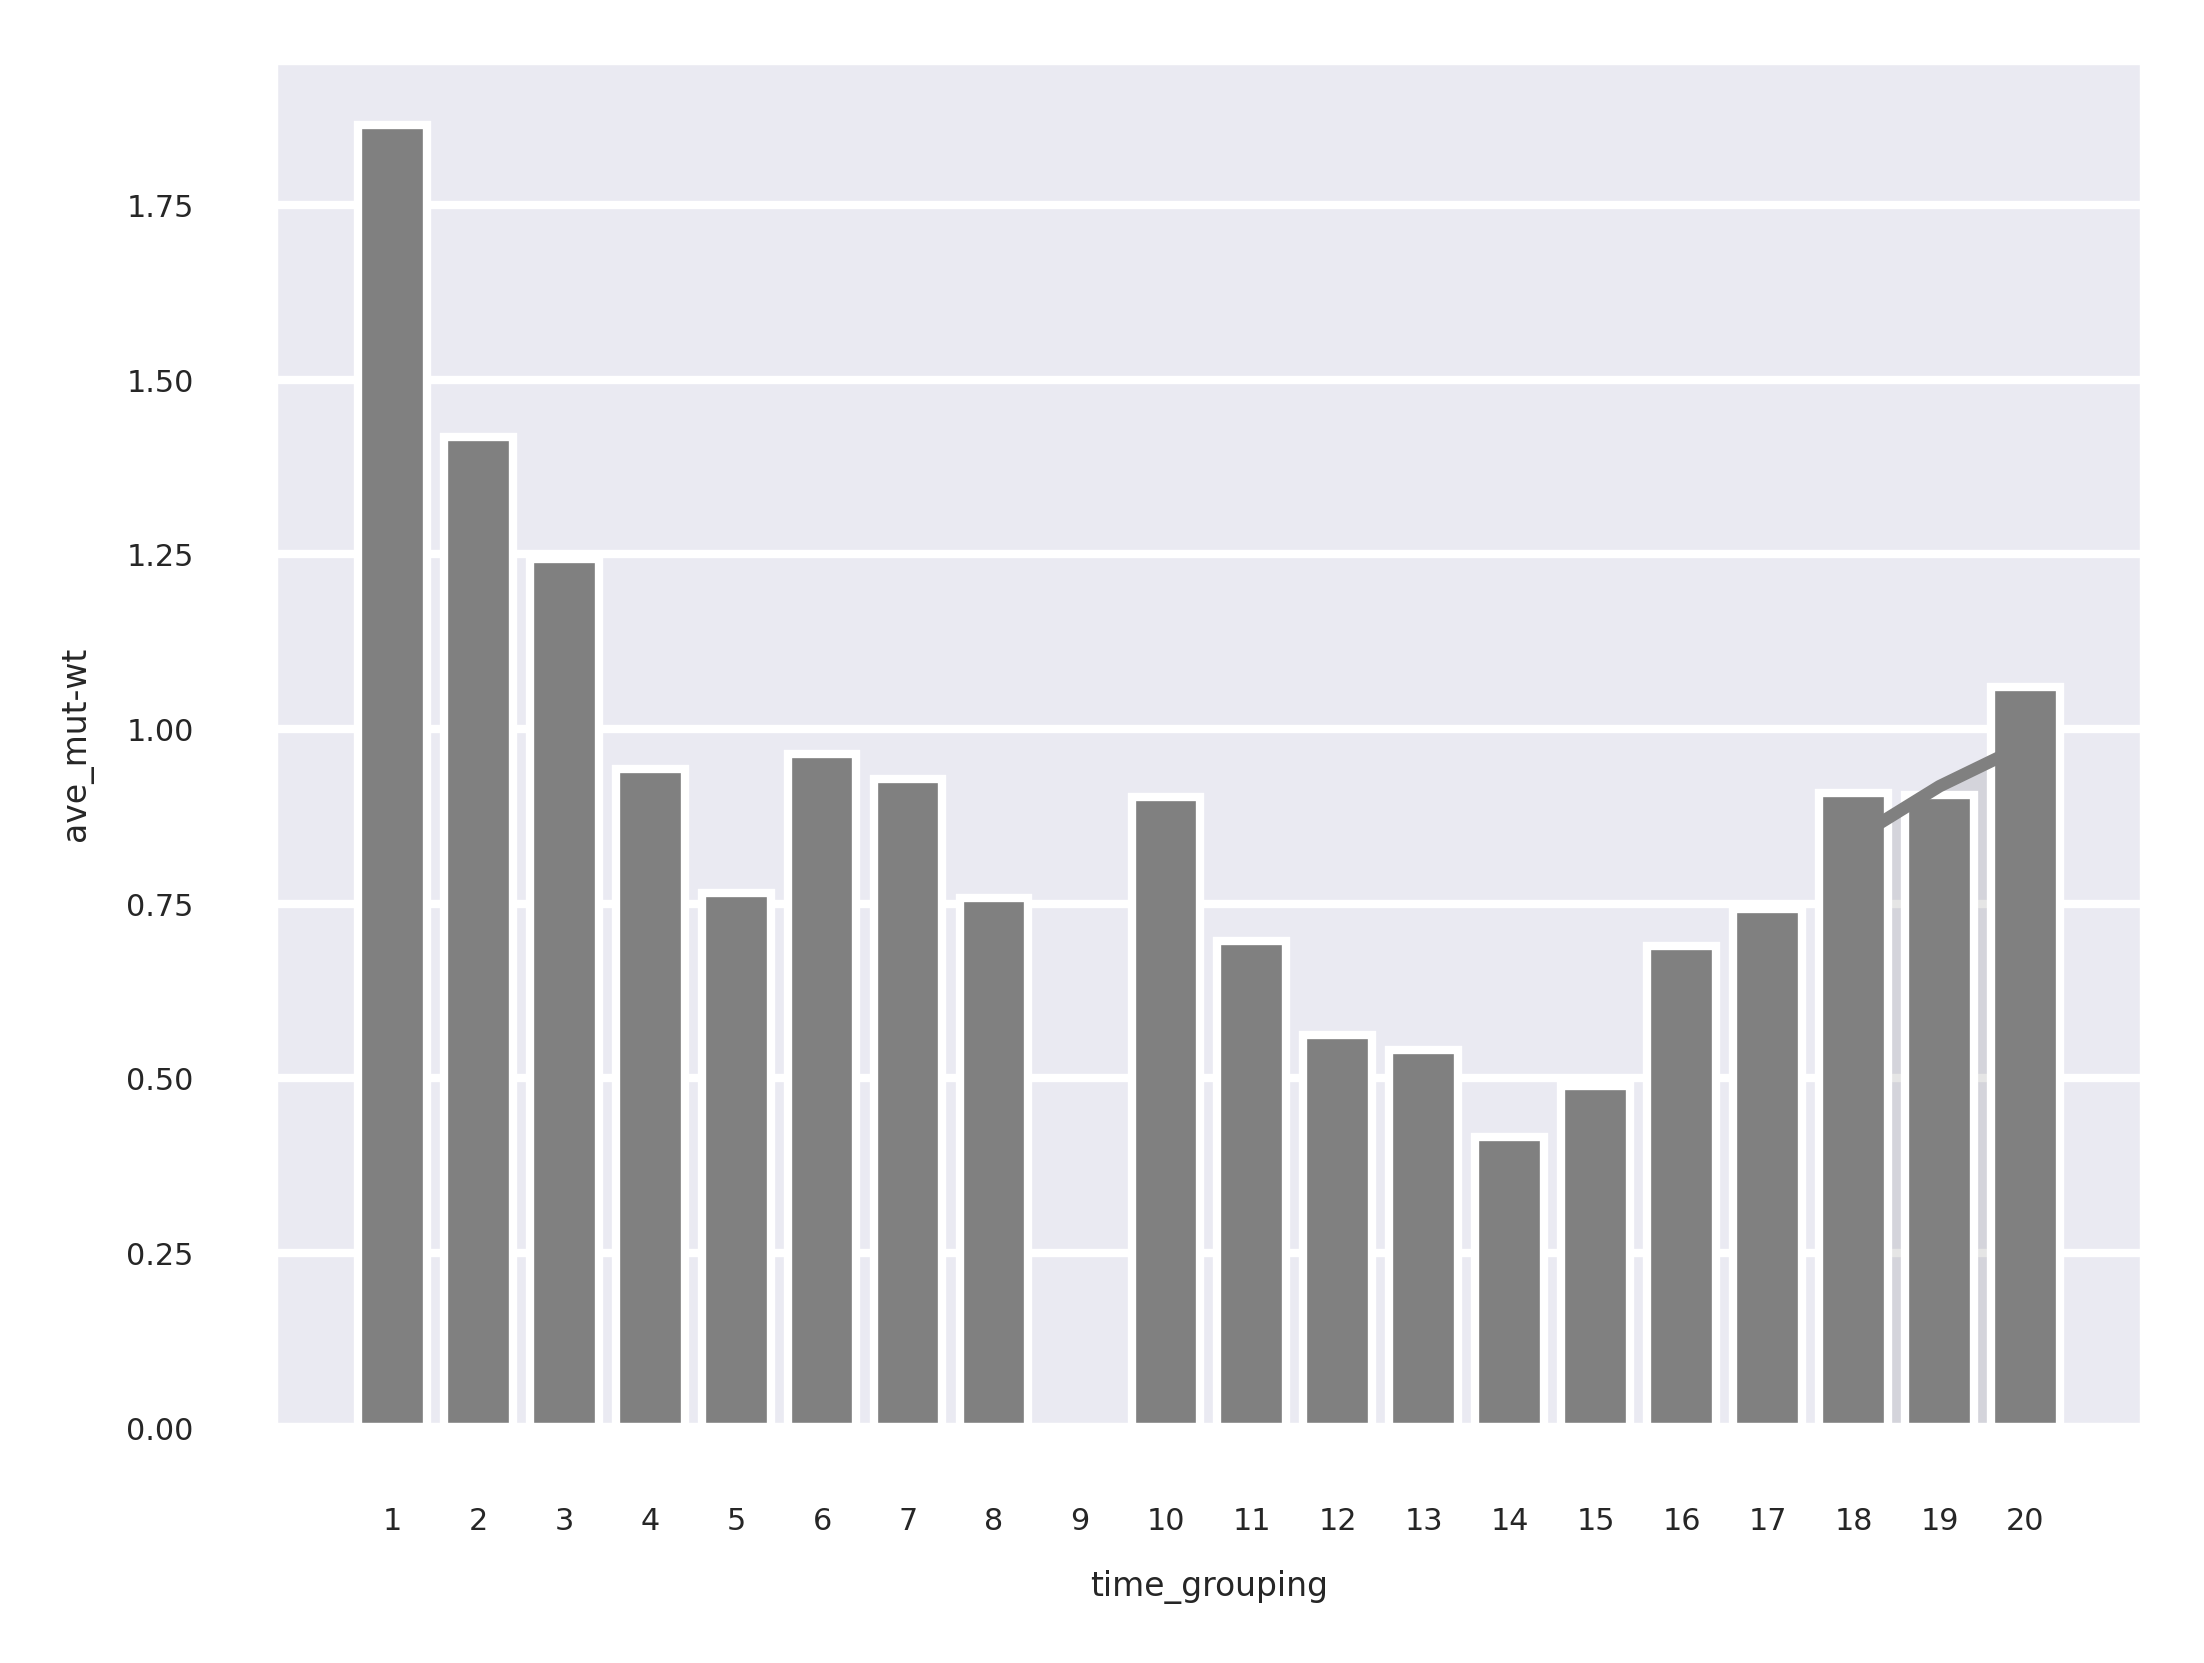

In [12]:
p_diff = sns.clustermap(
        y_diff,
        pivot_kws=None,
        method='average',
        metric='euclidean',
        z_score=None,
        standard_scale=None,
        row_cluster=True,
        col_cluster=False,
        row_linkage=None,
        figsize=(4, 50), 
        col_linkage=None,
        row_colors=None,
        col_colors=timecolors,
        mask=None,
        dendrogram_ratio=0.2,
        colors_ratio=0.03,
        cbar_pos=(1, 0, 0.1, 0.15),
        tree_kws=None,
        cmap='RdYlBu_r',
        yticklabels=True,
        xticklabels=False,
        vmax=1, vmin=-1,
    )
p_diff.ax_heatmap.set_xlabel('')

p_diff.savefig(os.path.join(pfp, 'top_dyn_genes_DIFF_{}_ctypeNORM.pdf'.format(ctype)))

x_diff_melted = x_diff.T.reset_index().melt(id_vars='time_grouping', var_name='topGenes', value_name='mut-wt')
fig, ax = plt.subplots(1,1, figsize=(4,3))
p = sns.regplot('time_grouping', 'mut-wt', data=x_diff_melted, 
            x_estimator=None, x_bins=None, x_ci='ci', scatter=True, 
            fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, 
            order=1, logistic=False, lowess=True, robust=False, logx=False, x_partial=None, 
            y_partial=None, truncate=True, dropna=True, x_jitter=0.5, y_jitter=None, 
            label=None, color='gray', marker='o', scatter_kws={'s':1, 'alpha':0.6, 'lw':0}, line_kws=None, ax=ax)
fig.savefig(os.path.join(pfp, 'top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

fig, ax = plt.subplots(1,1, figsize=(4,3))
z = x_diff.abs().mean(axis=0).reset_index()
z = z.rename(columns={0:'ave_mut-wt'})

# histogram
sns.barplot(x='time_grouping', y='ave_mut-wt', data=z, color='gray', ax=ax)

# smoothed
yprime = gaussian_filter1d(
    z['ave_mut-wt'],
    2,
    axis=-1,
    order=0,
    output=None,
    mode='nearest',
    cval=0.0,
    truncate=4.0,
)
ax.plot(z['time_grouping']-1, yprime, color='gray')
ax.fill_between(z['time_grouping']-1, 0, yprime, color='gray', alpha=0.2)
fig.savefig(os.path.join(pfp, 'hist_top{}_mut-wtDIFF_{}.png'.format(ntop, ctype)))

x_diff = x_diff.reset_index()
x_diff['ctype'] = ctype
x_diff['top_wt'] = x_diff['index'].isin(wttop).astype(int)
x_diff['top_mut'] = x_diff['index'].isin(muttop).astype(int) # later give info gain val

results = results.append(x_diff, ignore_index=True)

# # intermediate save
# if verbose: # save every round
#     results.to_csv(os.path.join(pfp,'top{}_dyngenes_v2(DCN).csv'.format(ntop)))

print('\n... done evaluating {}.\n      took {}-min'.format(ctype, (time.time() - tic)/60))

# results.to_csv(os.path.join(pfp,'top{}_dyngenes.csv'.format(ntop)))